In [80]:
%matplotlib notebook
import gmaps
import matplotlib.pyplot as plt
import pandas as pd
import requests

from config import gkey,api_key
from census import Census

def coordinates(loc):
    params = {"address": loc, "key":gkey}
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    response = requests.get(base_url, params = params)
    place_geo = response.json()
    lat = place_geo['results'][0]["geometry"]['location']['lat']
    lng = place_geo['results'][0]["geometry"]['location']['lng']
    return lat, lng

c = Census(api_key, year=2018)
gmaps.configure(api_key = gkey)

In [103]:
df = pd.read_excel("Tables/Table_13_Hate_Crime_Incidents_per_Bias_Motivation_and_Quarter_by_State_and_Agency_2018.xlsm")
df.dropna(inplace=True)
ls = []
for x in df["Agency name"]:
    if '3' in x:
        #print(x)
        ls.append(x[:-1])
    else:
        ls.append(x)
df["Agency name"] = ls
df.head()

,State,Agency,Agency name,Race/Ethnicity/Ancestry,Religion,Sexual Orientation,Disability,Gender,Gender identity,1st quarter,2nd quarter,3rd quarter,4th quarter,Population
2,Alaska,Cities,Anchorage,1,0,0,0,0,0,0.0,0,1.0,0.0,291992.0
3,Alaska,Cities,Fairbanks,2,0,0,1,0,0,1.0,1,1.0,0.0,31635.0
4,Alaska,Cities,Juneau,0,2,0,0,0,0,0.0,0,2.0,0.0,31922.0
5,Alaska,Cities,Kotzebue,1,0,0,0,0,0,0.0,1,0.0,0.0,3273.0
9,Arizona,Cities,Coolidge,2,0,0,0,0,0,0.0,0,0.0,2.0,12815.0


In [4]:
dfloc = pd.read_csv("locations.csv")
dfloc["Loc"] = dfloc["State"] + "," + dfloc["Agency name"]

df["Loc"] = df["State"] + "," + df["Agency name"]
dfa = pd.merge(df,dfloc,on=["Loc","Loc"])
dfa = dfa.loc[:,['Loc', 'Lat', 'Lng','Population', 'Race/Ethnicity/Ancestry',
       'Religion', 'Sexual Orientation', 'Disability', 'Gender',
       'Gender identity']]
dfa["Total"] = dfa["Race/Ethnicity/Ancestry"] + dfa["Religion"] + dfa["Gender"] + dfa["Gender identity"] + dfa["Disability"]
loc = dfa.loc[:,["Lat","Lng"]]

In [16]:
# results saved to file locations.csv, not worth re-running outside of error
'''
df["Lat"] = ""
df["Lng"] = ""
for i,r in df.iterrows():
    st = r[2] + ',' + r[0]
    lat,lng = coordinates(st)
    df.loc[i,["Lat"]] = lat
    df.loc[i,["Lng"]] = lng

dfloc = df.loc[:,['State', 'Agency name', 'Lat', 'Lng']]

dfloc.to_csv("locations.csv")
'''

'\ndf["Lat"] = ""\ndf["Lng"] = ""\nfor i,r in df.iterrows():\n    st = r[2] + \',\' + r[0]\n    lat,lng = coordinates(st)\n    df.loc[i,["Lat"]] = lat\n    df.loc[i,["Lng"]] = lng\n\ndfloc = df.loc[:,[\'State\', \'Agency name\', \'Lat\', \'Lng\']]\n\ndfloc.to_csv("locations.csv")\n'

<IPython.core.display.Javascript object>


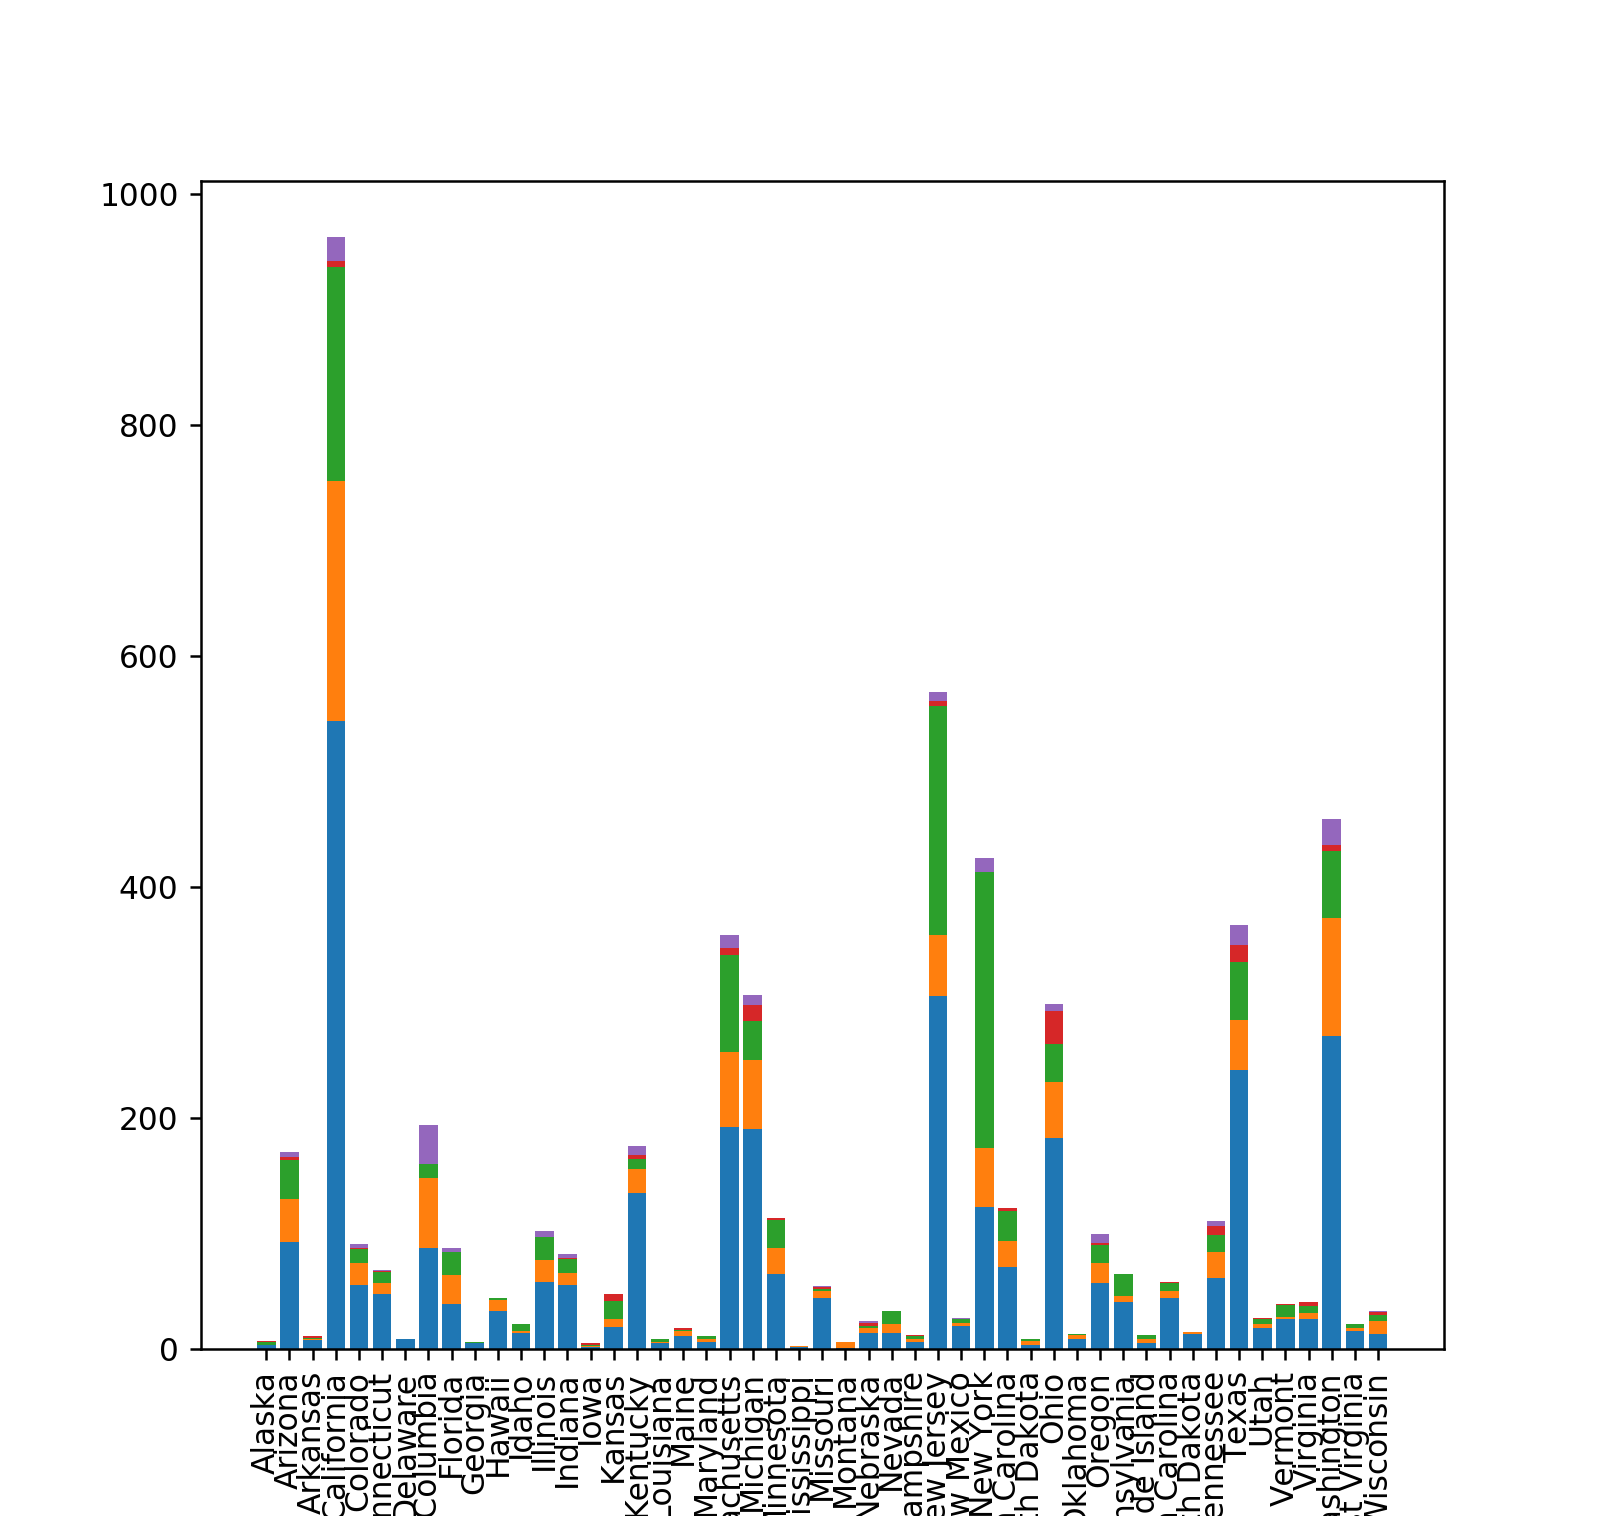

In [82]:
dfg = df.groupby("State").sum()
dfg.loc[:,['Race/Ethnicity/Ancestry', 'Religion', 'Sexual Orientation',
       'Disability', 'Gender', 'Gender identity']]
dfg["Total"] = dfg["Race/Ethnicity/Ancestry"] + dfg["Religion"] + dfg["Gender"] + dfg["Gender identity"] + dfg["Disability"] + dfg["Sexual Orientation"]

plt.bar(range(dfg.shape[0]),dfg["Race/Ethnicity/Ancestry"])
plt.bar(range(dfg.shape[0]),dfg["Sexual Orientation"],bottom=dfg["Race/Ethnicity/Ancestry"])
plt.bar(range(dfg.shape[0]),dfg["Religion"], bottom = dfg["Race/Ethnicity/Ancestry"]+ dfg["Sexual Orientation"])
plt.bar(range(dfg.shape[0]),dfg["Disability"], bottom = dfg["Race/Ethnicity/Ancestry"] + dfg["Sexual Orientation"]+ dfg["Religion"])
plt.bar(range(dfg.shape[0]),dfg["Gender"] + dfg["Gender identity"], bottom = dfg["Race/Ethnicity/Ancestry"]+ dfg["Sexual Orientation"] + dfg["Religion"] + dfg["Disability"])

ind = list(dfg.index)
plt.xticks(range(dfg.shape[0]),labels=ind, rotation = 90)
plt.show()

<IPython.core.display.Javascript object>


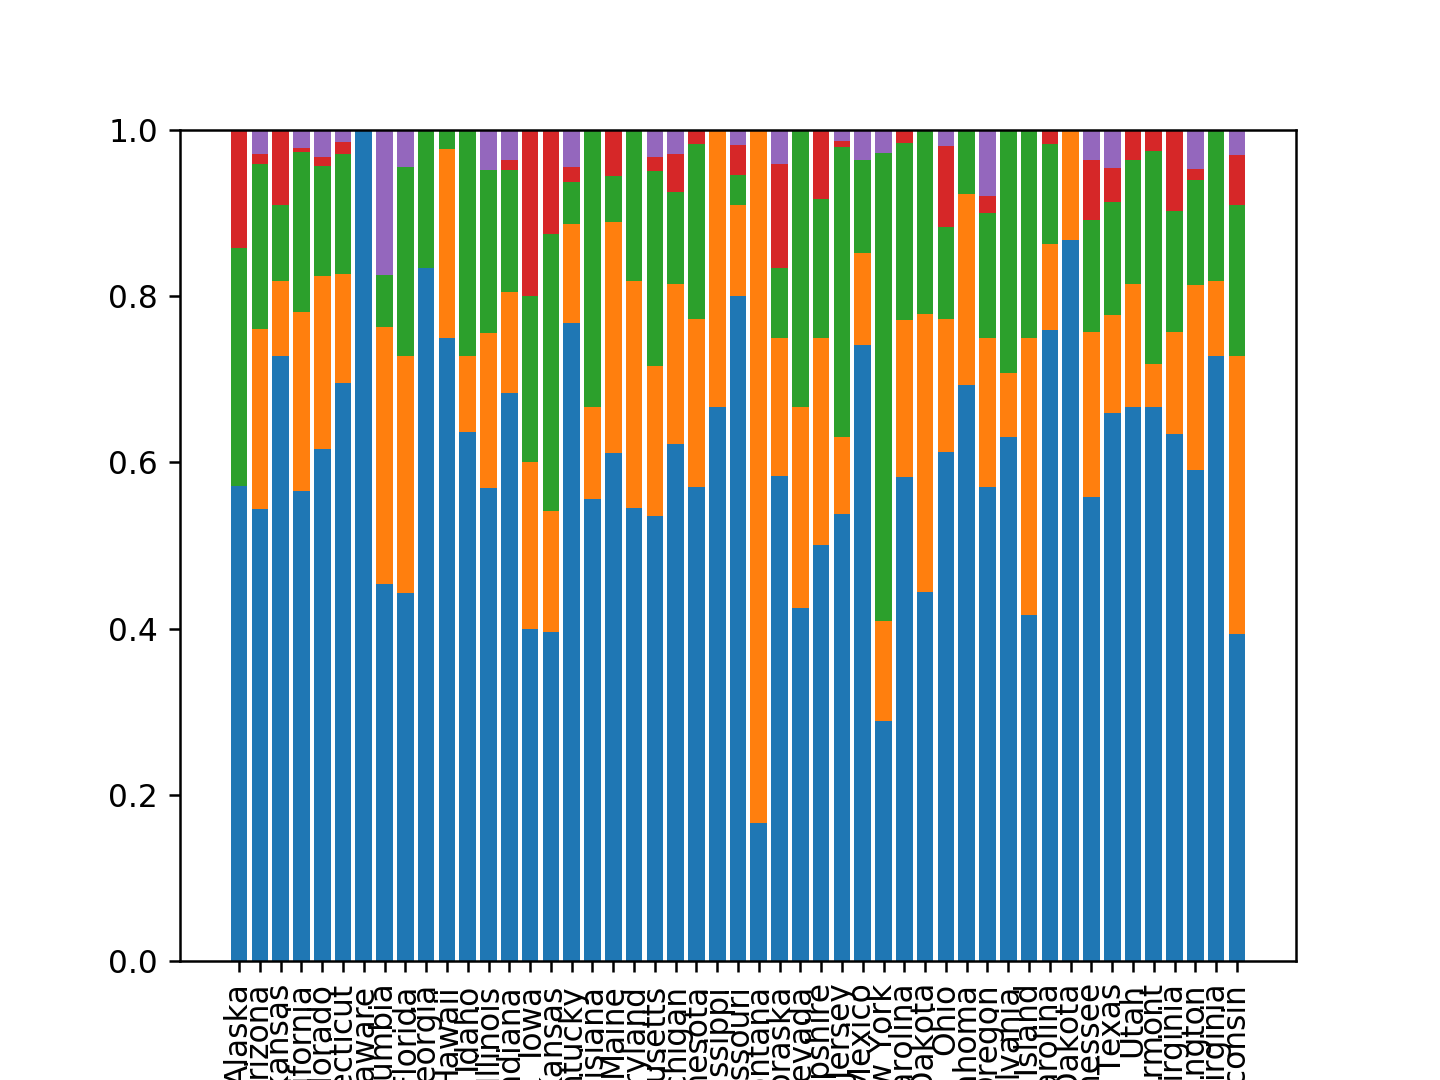

In [83]:
dfgp = dfg.loc[:,['Race/Ethnicity/Ancestry', 'Religion', 'Sexual Orientation',
       'Disability', 'Gender', 'Gender identity', 'Population', 'Total']]
dfgp["Race/Ethnicity/Ancestry"] = dfg["Race/Ethnicity/Ancestry"]/dfg["Total"]
dfgp["Disability"] = dfg["Disability"]/dfg["Total"]
dfgp["Religion"] = dfg["Religion"]/dfg["Total"]
dfgp["Gender identity"] = dfg["Gender identity"]/dfg["Total"]
dfgp["Gender"] = dfg["Gender"]/dfg["Total"]
dfgp["Sexual Orientation"] = dfg["Sexual Orientation"]/dfg["Total"]


plt.bar(range(dfg.shape[0]),dfgp["Race/Ethnicity/Ancestry"])
plt.bar(range(dfg.shape[0]),dfgp["Sexual Orientation"],bottom=dfgp["Race/Ethnicity/Ancestry"])
plt.bar(range(dfg.shape[0]),dfgp["Religion"], bottom = dfgp["Race/Ethnicity/Ancestry"]+ dfgp["Sexual Orientation"])
plt.bar(range(dfg.shape[0]),dfgp["Disability"], bottom = dfgp["Race/Ethnicity/Ancestry"] + dfgp["Sexual Orientation"]+ dfgp["Religion"])
plt.bar(range(dfg.shape[0]),dfgp["Gender"] + dfgp["Gender identity"], bottom = dfgp["Race/Ethnicity/Ancestry"]+ dfgp["Sexual Orientation"] + dfgp["Religion"] + dfgp["Disability"])

ind = list(dfg.index)
plt.xticks(range(dfg.shape[0]),labels=ind, rotation = 90)
plt.show()


<IPython.core.display.Javascript object>


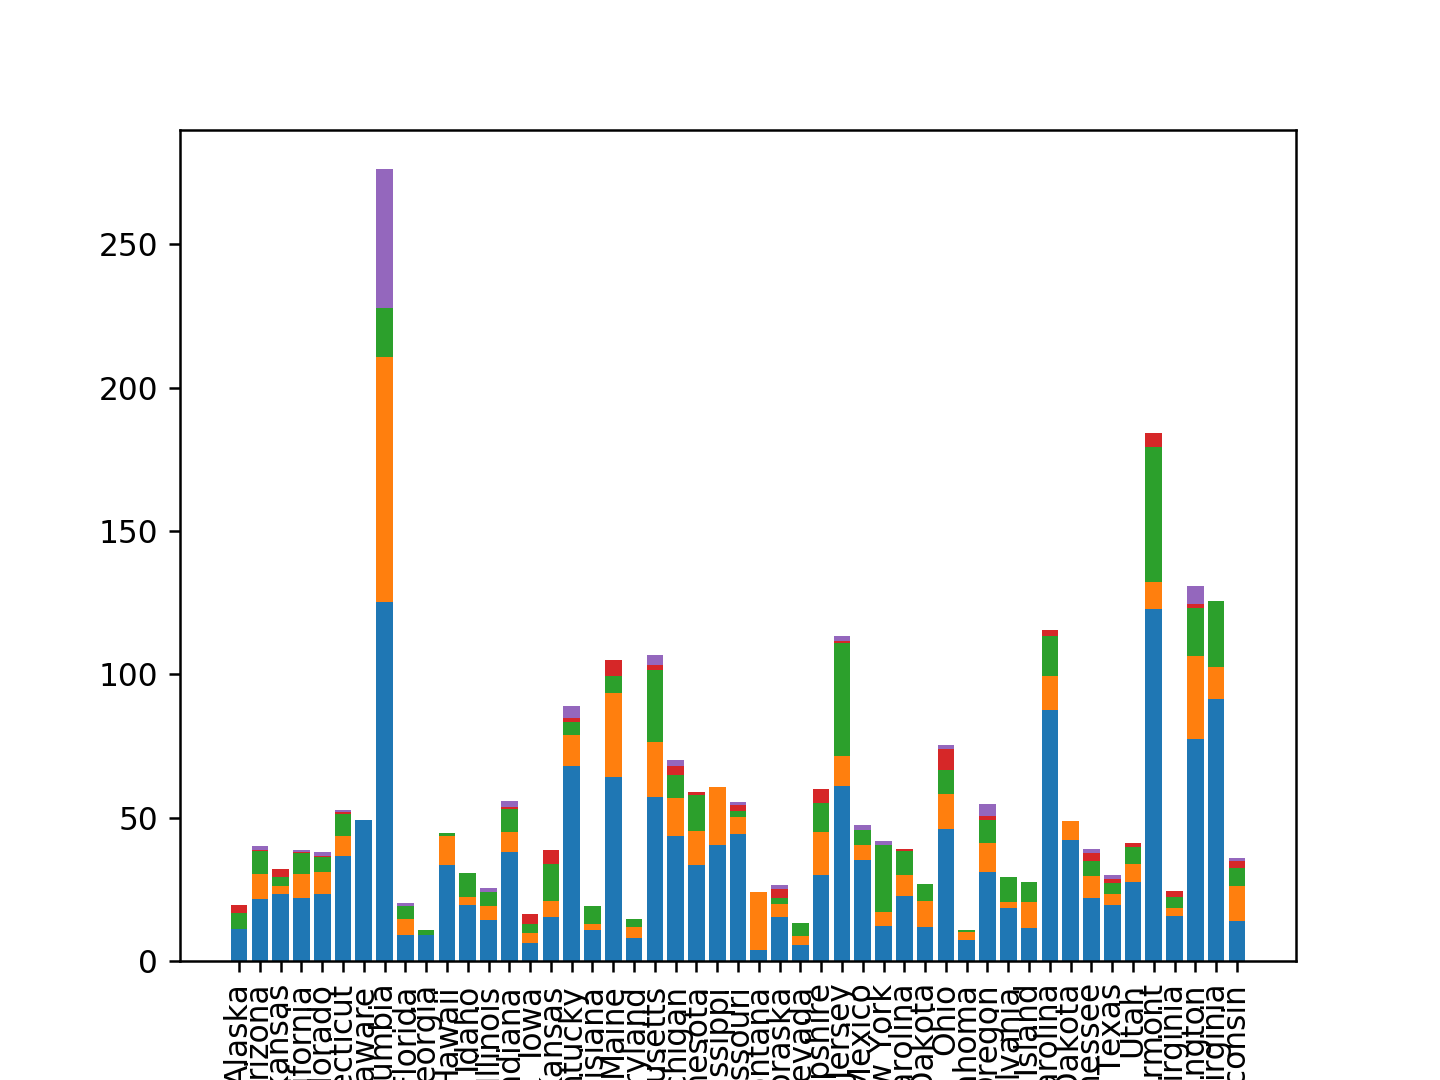

State
Alaska                   19.508280
Arizona                  39.997633
Arkansas                 32.134427
California               38.842371
Colorado                 37.946518
Connecticut              52.788414
Delaware                 49.328854
District of Columbia    276.174275
Florida                  20.258578
Georgia                  10.892356
Hawaii                   44.805650
Idaho                    30.890243
Illinois                 25.439213
Indiana                  55.953485
Iowa                     16.299440
Kansas                   38.901298
Kentucky                 88.941940
Louisiana                19.335254
Maine                   105.183809
Maryland                 14.608408
Massachusetts           106.752751
Michigan                 70.008146
Minnesota                58.936049
Mississippi              60.704168
Missouri                 55.360898
Montana                  24.244285
Nebraska                 26.406882
Nevada                   13.178772
New Hampshire 

In [100]:
dfgpop = dfg.loc[:,['Race/Ethnicity/Ancestry', 'Religion', 'Sexual Orientation',
       'Disability', 'Gender', 'Gender identity', 'Population', 'Total']]
dfgpop["Race/Ethnicity/Ancestry"] = dfg["Race/Ethnicity/Ancestry"]/dfg["Population"]
dfgpop["Disability"] = dfg["Disability"]/dfg["Population"]
dfgpop["Religion"] = dfg["Religion"]/dfg["Population"]
dfgpop["Gender identity"] = dfg["Gender identity"]/dfg["Population"]
dfgpop["Gender"] = dfg["Gender"]/dfg["Population"]
dfgpop["Sexual Orientation"] = dfg["Sexual Orientation"]/dfg["Population"]
dfgpop = dfgpop.loc[:,['Race/Ethnicity/Ancestry', 'Religion', 'Sexual Orientation','Disability', 'Gender', 'Gender identity']] * 1000000

plt.bar(range(dfg.shape[0]),dfgpop["Race/Ethnicity/Ancestry"])
plt.bar(range(dfg.shape[0]),dfgpop["Sexual Orientation"],bottom=dfgpop["Race/Ethnicity/Ancestry"])
plt.bar(range(dfg.shape[0]),dfgpop["Religion"], bottom = dfgpop["Race/Ethnicity/Ancestry"]+ dfgpop["Sexual Orientation"])
plt.bar(range(dfg.shape[0]),dfgpop["Disability"], bottom = dfgpop["Race/Ethnicity/Ancestry"] + dfgpop["Sexual Orientation"]+ dfgpop["Religion"])
plt.bar(range(dfg.shape[0]),dfgpop["Gender"] + dfgpop["Gender identity"], bottom = dfgpop["Race/Ethnicity/Ancestry"]+ dfgpop["Sexual Orientation"] + dfgpop["Religion"] + dfgpop["Disability"])

ind = list(dfg.index)
plt.xticks(range(dfg.shape[0]),labels=ind, rotation = 90)
plt.show()

<IPython.core.display.Javascript object>


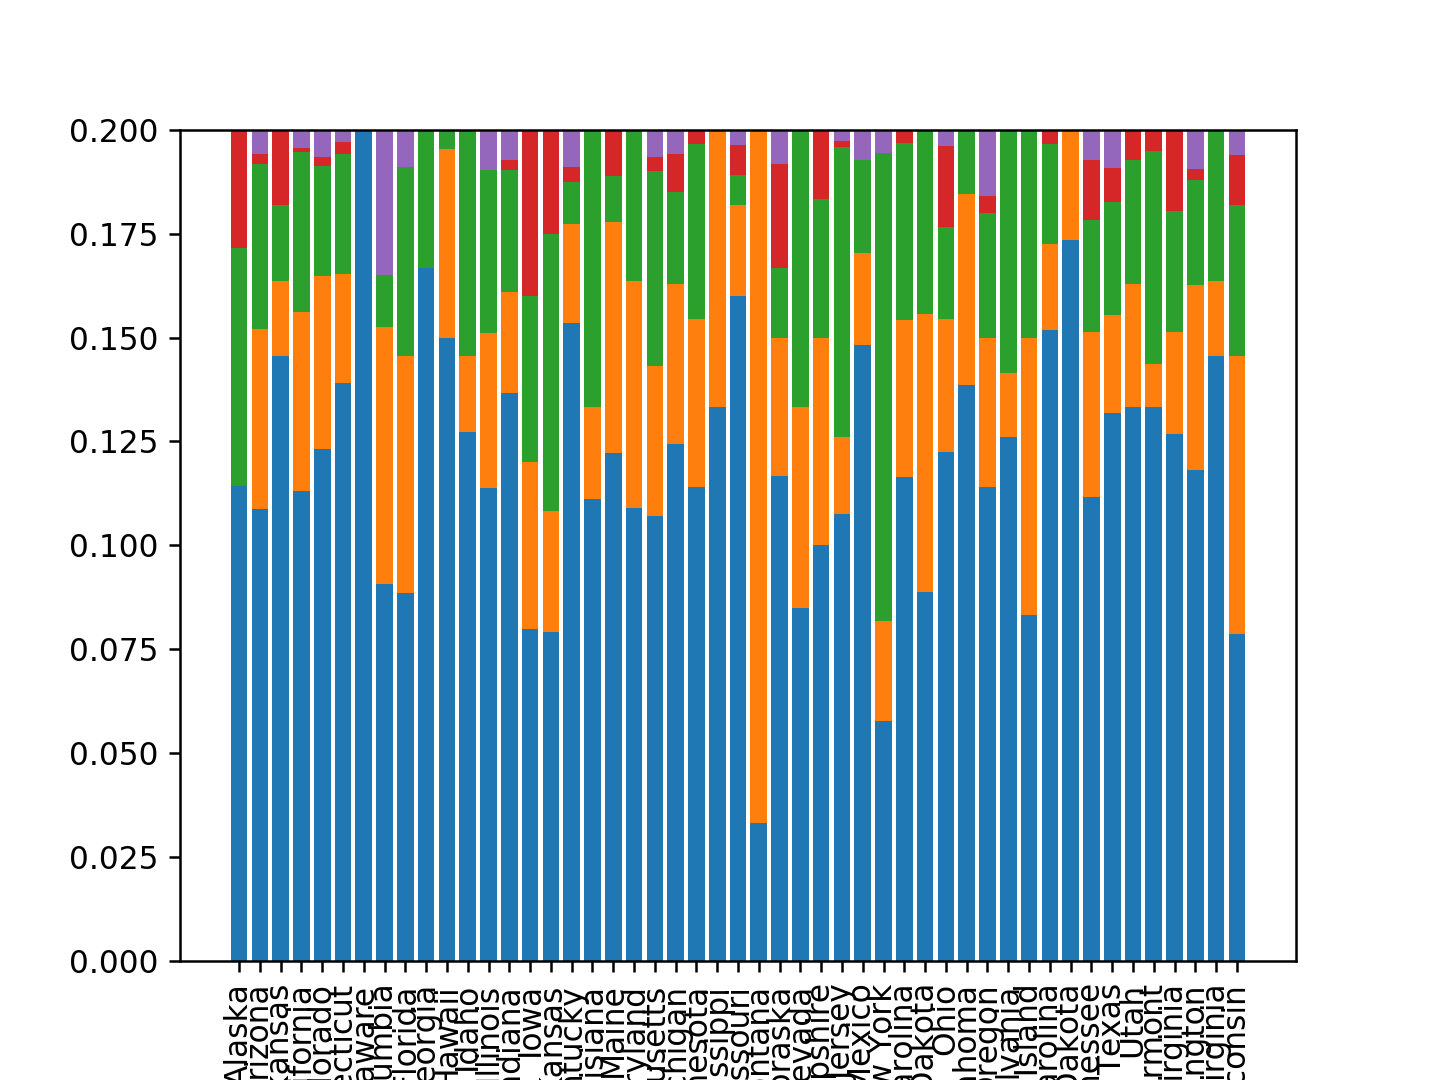

In [106]:
dfgpop["Total"] = dfgpop.sum(axis=1)

for x in dfgpop.columns:
    dfgpop[x] = dfgpop[x]/dfgpop["Total"]

plt.bar(range(dfg.shape[0]),dfgpop["Race/Ethnicity/Ancestry"])
plt.bar(range(dfg.shape[0]),dfgpop["Sexual Orientation"],bottom=dfgpop["Race/Ethnicity/Ancestry"])
plt.bar(range(dfg.shape[0]),dfgpop["Religion"], bottom = dfgpop["Race/Ethnicity/Ancestry"]+ dfgpop["Sexual Orientation"])
plt.bar(range(dfg.shape[0]),dfgpop["Disability"], bottom = dfgpop["Race/Ethnicity/Ancestry"] + dfgpop["Sexual Orientation"]+ dfgpop["Religion"])
plt.bar(range(dfg.shape[0]),dfgpop["Gender"] + dfgpop["Gender identity"], bottom = dfgpop["Race/Ethnicity/Ancestry"]+ dfgpop["Sexual Orientation"] + dfgpop["Religion"] + dfgpop["Disability"])

ind = list(dfg.index)
plt.xticks(range(dfg.shape[0]),labels=ind, rotation = 90)
plt.show()

In [108]:
f = gmaps.figure()
l = gmaps.symbol_layer(loc)
f.add_layer(l)
f

Figure(layout=FigureLayout(height='420px'))

In [6]:
f1 = gmaps.figure()
l = gmaps.heatmap_layer(loc, weights=dfa["Population"])
f1.add_layer(l)
f1

Figure(layout=FigureLayout(height='420px'))

In [9]:
c.acs.get(("NAME", "B19013_001E", "B01003_001E", "B01002_001E",
                          "B19301_001E",
                          "B17001_002E", "B23025_005E"), {'for': 'state:*'})


[{'NAME': 'Minnesota',
  'B19013_001E': 68411.0,
  'B01003_001E': 5527358.0,
  'B01002_001E': 37.9,
  'B19301_001E': 36245.0,
  'B17001_002E': 547442.0,
  'B23025_005E': 119218.0,
  'state': '27'},
 {'NAME': 'Mississippi',
  'B19013_001E': 43567.0,
  'B01003_001E': 2988762.0,
  'B01002_001E': 37.2,
  'B19301_001E': 23434.0,
  'B17001_002E': 599795.0,
  'B23025_005E': 110036.0,
  'state': '28'},
 {'NAME': 'Missouri',
  'B19013_001E': 53560.0,
  'B01003_001E': 6090062.0,
  'B01002_001E': 38.5,
  'B19301_001E': 29537.0,
  'B17001_002E': 837930.0,
  'B23025_005E': 155958.0,
  'state': '29'},
 {'NAME': 'Montana',
  'B19013_001E': 52559.0,
  'B01003_001E': 1041732.0,
  'B01002_001E': 39.8,
  'B19301_001E': 29765.0,
  'B17001_002E': 139063.0,
  'B23025_005E': 22433.0,
  'state': '30'},
 {'NAME': 'Nebraska',
  'B19013_001E': 59116.0,
  'B01003_001E': 1904760.0,
  'B01002_001E': 36.4,
  'B19301_001E': 31101.0,
  'B17001_002E': 213790.0,
  'B23025_005E': 36545.0,
  'state': '31'},
 {'NAME': 'Nev

In [10]:
from census_vars import censuskey
censuskey

{'income': 'B19013_001E',
 'income_per_capita': 'B19301_001E',
 'employment_labor_force': 'B23025_002E',
 'employment_not_labor_force': 'B23025_007E',
 'employment_civilian_labor_force': 'B23025_003E',
 'employment_employed': 'B23025_004E',
 'employment_unemployed': 'B23025_005E',
 'employment_armed_forces': 'B23025_006E',
 'employment_male_management_business_science_and_arts_occupations': 'C24010_003E',
 'employment_male_management_business_and_financial_occupations': 'C24010_004E',
 'employment_male_management_occupations': 'C24010_005E',
 'employment_male_business_and_financial_operations_occupations': 'C24010_006E',
 'employment_male_computer_engineering_and_science_occupations': 'C24010_007E',
 'employment_male_computer_and_mathematical_occupations': 'C24010_008E',
 'employment_male_architecture_and_engineering_occupations': 'C24010_009E',
 'employment_male_life_physical_and_social_science_occupations': 'C24010_010E',
 'employment_male_education_legal_community_service_arts_and_m

In [35]:
dfloc

,Unnamed: 0,State,Agency name,Lat,Lng,Loc
0,2,Alaska,Anchorage,61.218056,-149.900278,"Alaska,Anchorage"
1,3,Alaska,Fairbanks,64.837778,-147.716389,"Alaska,Fairbanks"
2,4,Alaska,Juneau,58.301944,-134.419722,"Alaska,Juneau"
3,5,Alaska,Kotzebue,66.898333,-162.596667,"Alaska,Kotzebue"
4,9,Arizona,Coolidge,32.977839,-111.517624,"Arizona,Coolidge"
...,...,...,...,...,...,...
1458,2203,Wisconsin,Seymour,44.514988,-88.330380,"Wisconsin,Seymour"
1459,2204,Wisconsin,Sheboygan,43.750828,-87.714530,"Wisconsin,Sheboygan"
1460,2205,Wisconsin,Stevens Point,44.523579,-89.574563,"Wisconsin,Stevens Point"
1461,2206,Wisconsin,Waterloo,43.183884,-88.988442,"Wisconsin,Waterloo"
